# Collect Data and Train Gaussian Processes

## Gaussian Processes

In [6]:
import torch
import gpytorch
import numpy as np

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000, device=None):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.tensor(Y, dtype=torch.float32, device=self.device).flatten()  # ensure 1D

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32, device=self.device)
        Y_new = torch.tensor(Y_new, dtype=torch.float32, device=self.device).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        # self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        # self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        self.X_mean = self.X_train.mean(0)
        self.X_std = self.X_train.std(0) + 1e-8
        self.Y_mean = self.Y_train.mean(0)
        self.Y_std = self.Y_train.std(0) + 1e-8

        self.Xn = (self.X_train - self.X_mean) / self.X_std
        self.Yn = (self.Y_train - self.Y_mean) / self.Y_std

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.detach().cpu().numpy()
        Y_train = self.Y_train.detach().cpu().numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1]
                                  ).to(self.device)

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean * self.Y_std + self.Y_mean
            var = pred.variance * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()


## Recolección de datos

Using device: cuda
✅ Simulador inicializado correctamente.


Rollout MuJoCo: 100%|██████████| 8000/8000 [00:00<00:00, 16472.10it/s]


✅ Datos recolectados:
  states     : (8000, 6)
  actions    : (8000, 2)
  delta_s    : (8000, 6)
✅ Dataset para GP:
  X: (2000, 8)  (state+action)
  Y: (2000, 6)  (delta_state)


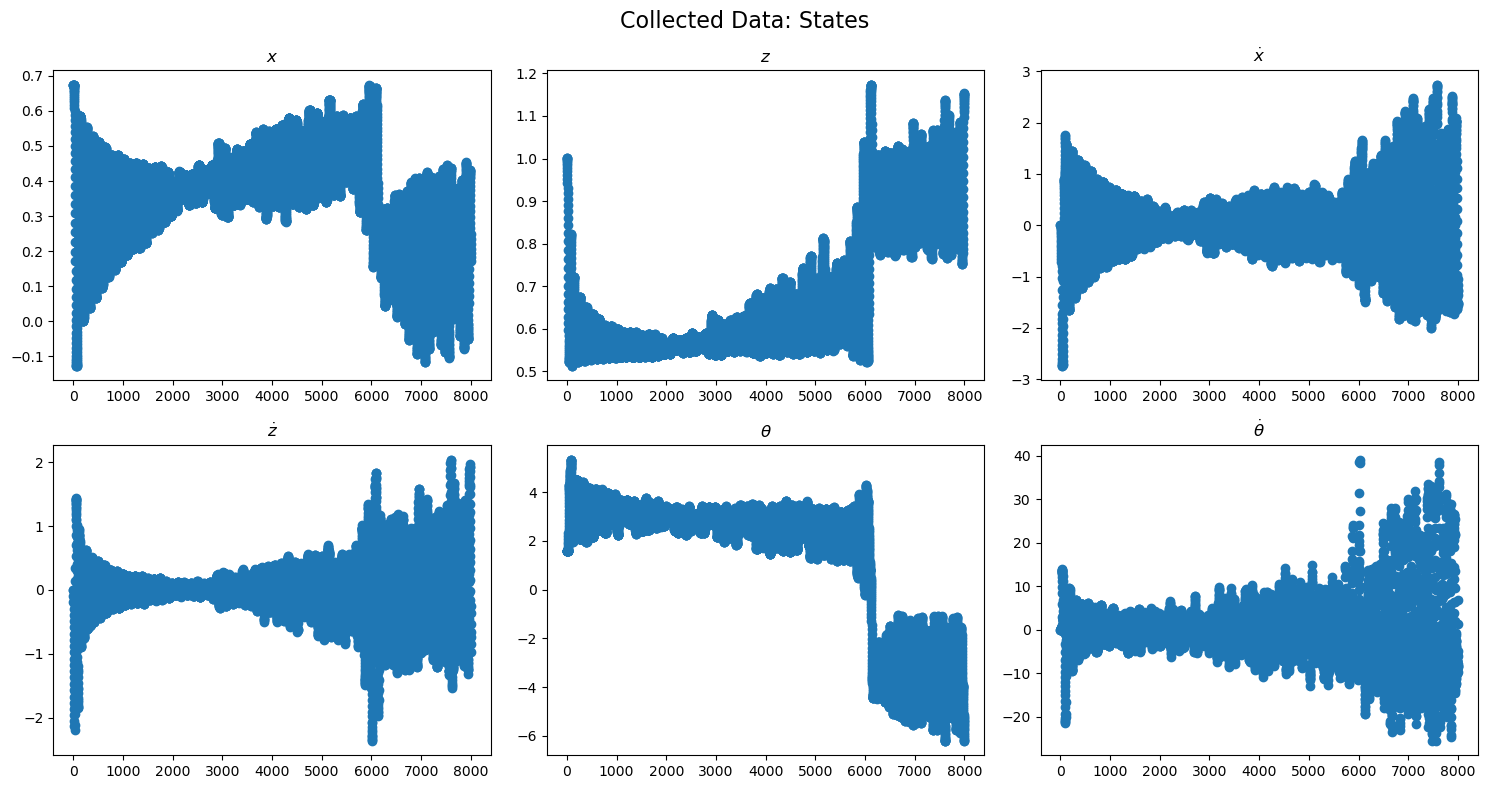

In [7]:
# ===============================================
# 1. Imports y setup MuJoCo + Torch
# ===============================================
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # solo para evitar el warning de OpenMP

import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Opcional: elegir device para Torch (aunque GPManager original trabaja en CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ===============================================
# 2. Crear modelo MuJoCo a partir del XML
# ===============================================
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

print("✅ Simulador inicializado correctamente.")

# ===============================================
# 3. Utilidades para ángulos y estado del dron
# ===============================================

def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos bruscos de ±2π.
    """
    if angle_prev is None:
        return angle_raw

    delta = angle_raw - angle_prev
    if delta > np.pi:
        angle_raw -= 2 * np.pi
    elif delta < -np.pi:
        angle_raw += 2 * np.pi
    return angle_raw


def quat_to_roll_x(quat, prev_roll=None):
    """
    Convierte cuaternión [w,x,y,z] a ángulo de roll alrededor de X,
    y lo hace continuo usando unwrap.
    """
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None):
    """
    Construye el vector de estado:
        s = [x, z, x_dot, z_dot, theta, theta_dot]
    a partir de los sensores definidos en el XML.
    """
    # Posición global
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # Velocidades lineales
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # Cuaternión del dron
    quat = data.sensor("quat_drone").data   # [w, x, y, z]
    roll_raw = quat_to_roll_x(quat, prev_theta)

    # Velocidad angular (rotvel_drone)
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]  # roll alrededor de 

    theta = roll_raw
    state = np.array([x, z, x_dot, z_dot, theta, theta_dot], dtype=np.float32)
    return state, theta

# ===============================================
# 4. Rollout aleatorio para recolectar datos
# ===============================================

def rollout_random(model, data, n_steps=5000):
    """
    Ejecuta el simulador con acciones aleatorias y devuelve:
        states:      [N, 6]
        actions:     [N, 2]
        next_states: [N, 6]
    """
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps), desc="Rollout MuJoCo"):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)

        # Acción aleatoria en rango [0, 2], y la escalamos suave con el tiempo para no excitar demasiado al inicio
        scale = (step / n_steps)  # va de 0 → 1
        a_t = np.random.uniform(0.0, 2.0 * scale + 1e-3, size=2).astype(np.float32)
        data.ctrl[:] = a_t

        # Avanzar simulación un paso
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    states = np.stack(states, axis=0)
    actions = np.stack(actions, axis=0)
    next_states = np.stack(next_states, axis=0)

    return states, actions, next_states


# ===============================================
# 5. Recolectar datos y construir dataset (X, Y)
# ===============================================

N_STEPS = 8000  # puedes jugar con este número; cuidado con GPs (O(N^3))
states, actions, next_states = rollout_random(model, data, n_steps=N_STEPS)

delta_s = next_states - states  # [N, 6]

print("✅ Datos recolectados:")
print("  states     :", states.shape)
print("  actions    :", actions.shape)
print("  delta_s    :", delta_s.shape)

# Construimos entradas X = [state, action]
X_np = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]
Y_np = delta_s.astype(np.float32)                                     # [N, 6]

# Opcional: subsampling para que el GP sea manejable
SUBSAMPLE = 4  # usar cada k-ésimo dato
X_np = X_np[::SUBSAMPLE]
Y_np = Y_np[::SUBSAMPLE]

print("✅ Dataset para GP:")
print("  X:", X_np.shape, " (state+action)")
print("  Y:", Y_np.shape, " (delta_state)")


# ===============================================
# 6. Visualización de los datos recolectados
# ===============================================

rng = N_STEPS
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()


## GP Training

In [8]:
import os
import torch

MODEL_DIR = "data/gp_torch_models"
os.makedirs(MODEL_DIR, exist_ok=True)


def save_gp(gp, filepath):
    checkpoint = {
        "model_state": gp.model.state_dict(),
        "likelihood_state": gp.likelihood.state_dict(),
        "X_mean": gp.X_mean,
        "X_std": gp.X_std,
        "Y_mean": gp.Y_mean,
        "Y_std": gp.Y_std,
        "kernel": gp.kernel
    }
    torch.save(checkpoint, filepath)
    print(f"💾 GP guardado en {filepath}")


def load_gp(gp, filepath, X_example):
    checkpoint = torch.load(filepath, map_location=gp.device)

    gp.X_mean = checkpoint["X_mean"]
    gp.X_std = checkpoint["X_std"]
    gp.Y_mean = checkpoint["Y_mean"]
    gp.Y_std = checkpoint["Y_std"]

    gp.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(gp.device)

    gp.model = ExactGPModel(
        X_example,
        torch.zeros(len(X_example), device=gp.device),
        gp.likelihood,
        kernel=checkpoint["kernel"],
        ard_dims=X_example.shape[-1]
    ).to(gp.device)

    gp.model.load_state_dict(checkpoint["model_state"])
    gp.likelihood.load_state_dict(checkpoint["likelihood_state"])

    gp.model.eval()
    gp.likelihood.eval()
    gp.trained = True

    print(f"📂 GP cargado desde {filepath}")



# ===============================================
# 6. Entrenar o cargar modelos GP
# ===============================================

state_dim = Y_np.shape[1]   # 6
gps = []

for d in range(state_dim):
    gp_path = os.path.join(MODEL_DIR, f"gp_dim{d}.pth")
    gp = GPManager(kernel='RBF', iters=300)

    if os.path.exists(gp_path):
        print(f"📦 Cargando GP para dimensión {d}...")
        X_example = torch.tensor(X_np, dtype=torch.float32)
        load_gp(gp, gp_path, X_example)
    else:
        print(f"🧠 Entrenando GP para dimensión {d}...")
        gp.fit(X_np, Y_np[:, d])
        save_gp(gp, gp_path)

    gps.append(gp)

print("🎉 Todos los GPs listos (cargados o entrenados).")


# ===============================================
# 7. Función de predicción de un paso con el modelo GP
# ===============================================

def gp_dynamics_step(gps, state, action):
    """
    Calcula s_{t+1} = s_t + Δs usando la familia de GPs.
    state:  [6]  (numpy o torch)
    action: [2]
    """
    if isinstance(state, torch.Tensor):
        state = state.detach().cpu().numpy()
    if isinstance(action, torch.Tensor):
        action = action.detach().cpu().numpy()

    x = np.concatenate([state, action], axis=-1)[None, :]  # [1, 8]
    delta_pred = []

    for d, gp in enumerate(gps):
        mean_d, _ = gp.predict(x)   # mean_d: [1]
        delta_pred.append(mean_d[0])

    delta_pred = np.array(delta_pred, dtype=np.float32)  # [6]
    next_state_pred = state + delta_pred
    return next_state_pred, delta_pred

# Ejemplo rápido de uso:
s0 = states[0]
a0 = np.array([0.5, 0.5], dtype=np.float32)
s1_pred, ds_pred = gp_dynamics_step(gps, s0, a0)
print("Estado inicial s0:", s0)
print("Acción a0        :", a0)
print("Δs (GP)          :", ds_pred)
print("s1 (GP)          :", s1_pred)


📦 Cargando GP para dimensión 0...
📂 GP cargado desde data/gp_torch_models\gp_dim0.pth
📦 Cargando GP para dimensión 1...
📂 GP cargado desde data/gp_torch_models\gp_dim1.pth
📦 Cargando GP para dimensión 2...
📂 GP cargado desde data/gp_torch_models\gp_dim2.pth
📦 Cargando GP para dimensión 3...
📂 GP cargado desde data/gp_torch_models\gp_dim3.pth
📦 Cargando GP para dimensión 4...
📂 GP cargado desde data/gp_torch_models\gp_dim4.pth
📦 Cargando GP para dimensión 5...
📂 GP cargado desde data/gp_torch_models\gp_dim5.pth
🎉 Todos los GPs listos (cargados o entrenados).
Estado inicial s0: [0.675     1.00125   0.        0.        1.5707964 0.       ]
Acción a0        : [0.5 0.5]
Δs (GP)          : [-3.2587914e-04 -9.1169750e-07  5.5304067e-03  5.8041951e-03
  6.5597161e-03 -1.1408428e-02]
s1 (GP)          : [ 0.67467415  1.0012491   0.00553041  0.0058042   1.5773561  -0.01140843]


## Visualization

⚙️ Calculando predicciones GP (una sola vez)...
✅ Predicciones GP precomputadas.

🚀 Generando figuras de comparación compactas (2x3 por tipo)...


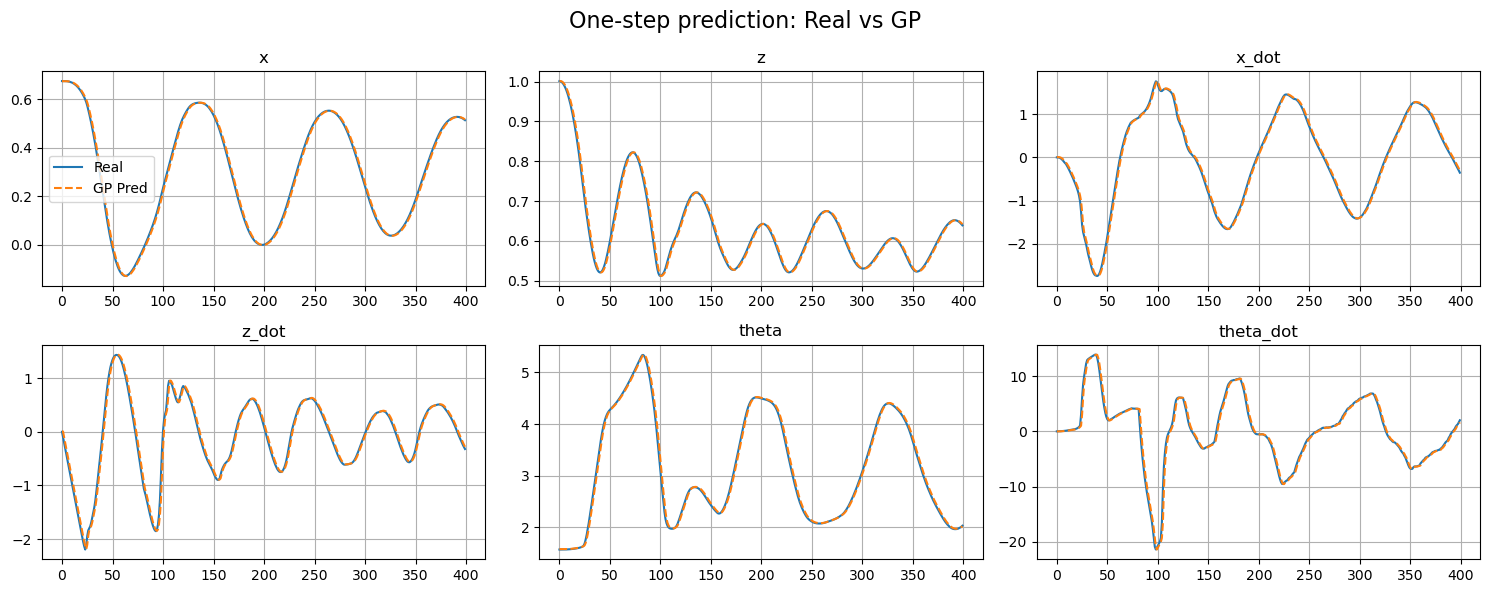

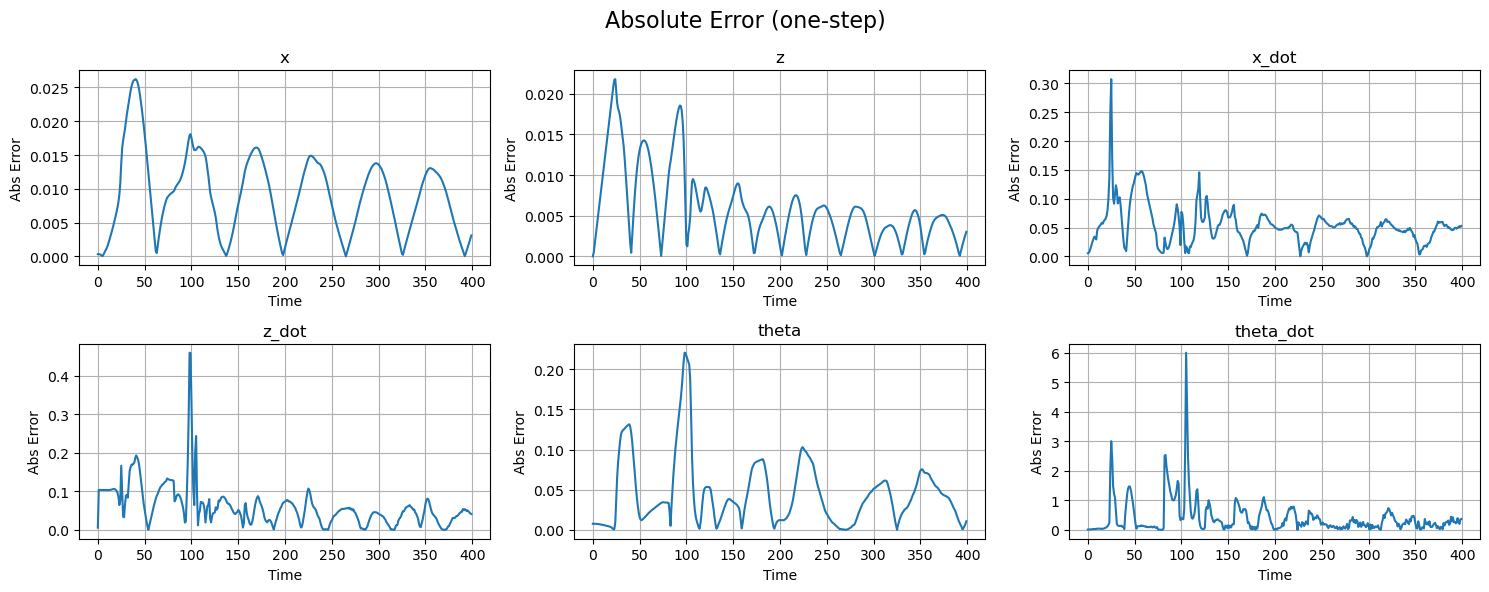

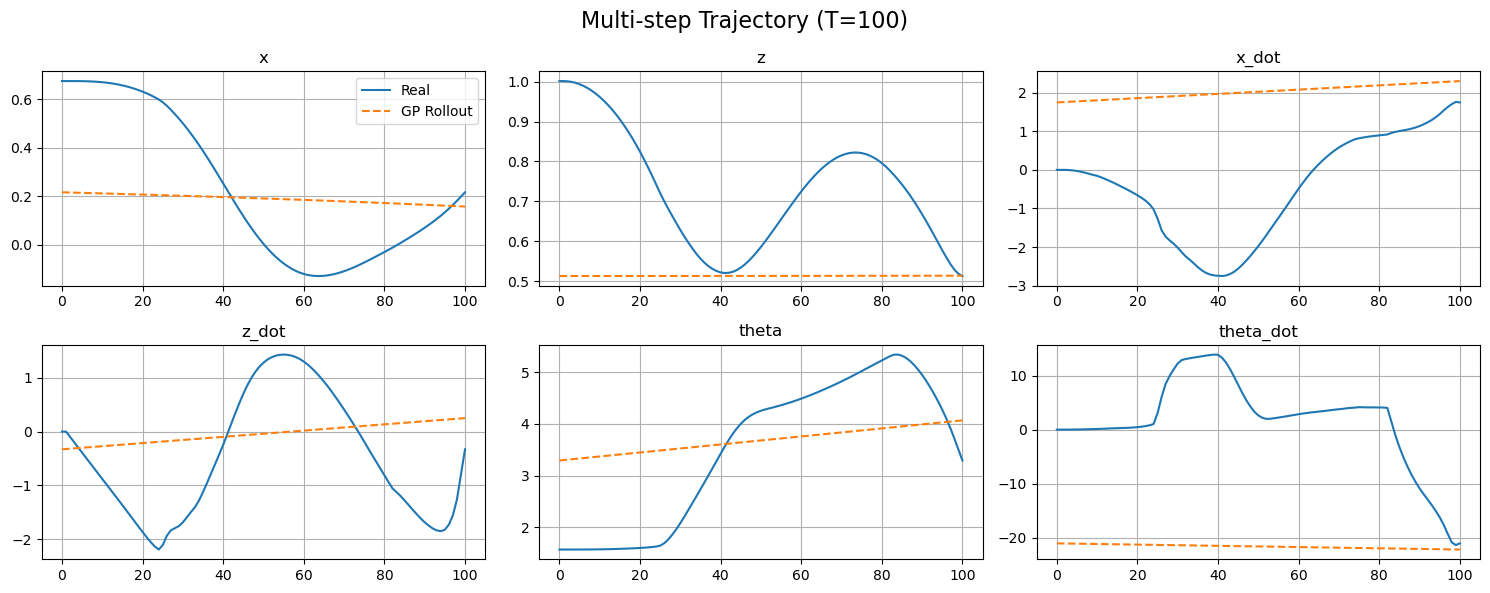

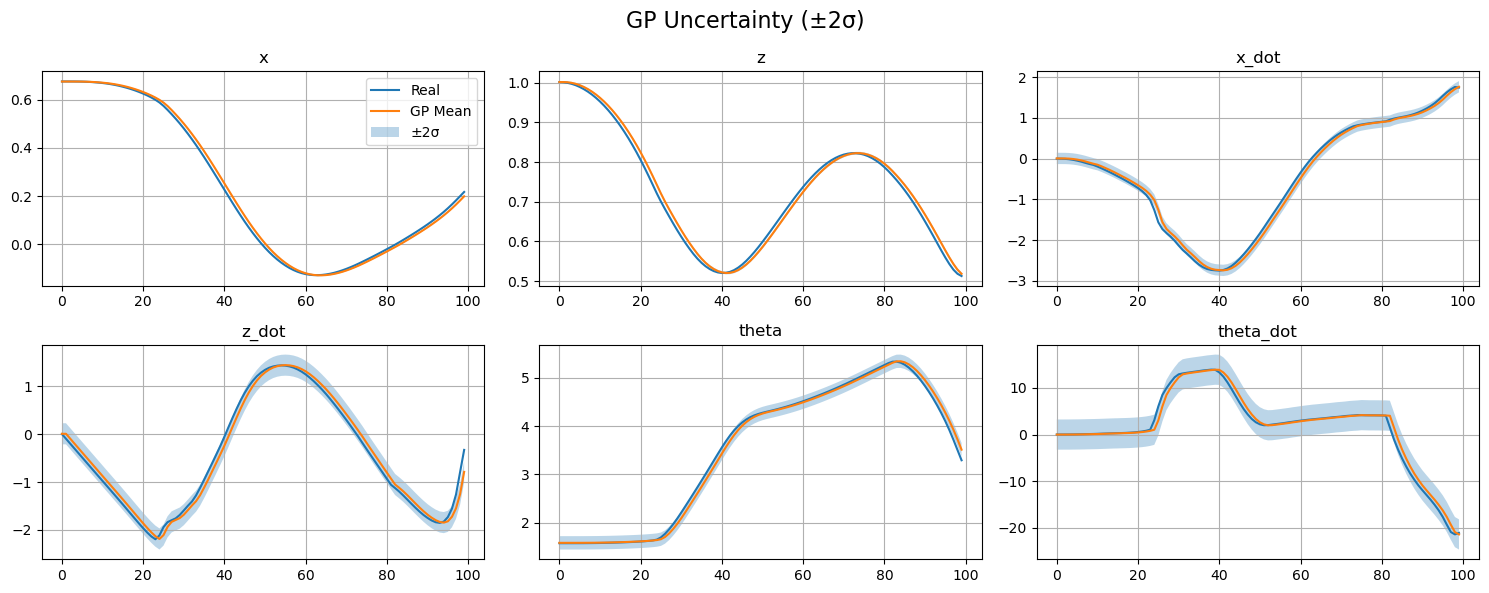


📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN
         x | RMSE=0.007262 | MAE=0.005379 | R²=0.9979
         z | RMSE=0.004955 | MAE=0.003333 | R²=0.9991
     x_dot | RMSE=0.059825 | MAE=0.040308 | R²=0.9933
     z_dot | RMSE=0.052307 | MAE=0.032652 | R²=0.9888
     theta | RMSE=0.071507 | MAE=0.048177 | R²=0.9994
 theta_dot | RMSE=1.402578 | MAE=0.939406 | R²=0.9613


In [ ]:
# ===============================================
# 8. PREDICCIONES GP PRECOMPUTADAS (UNA SOLA VEZ)
# ===============================================
import numpy as np
import matplotlib.pyplot as plt

DIM_LABELS = ["x", "z", "x_dot", "z_dot", "theta", "theta_dot"]

N, state_dim = states.shape

# Construir X_all = [state, action] para TODO el dataset
X_all = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]

# mean_delta_all[d]: Δs_pred_dim_d, var_delta_all[d]: var(Δs_dim_d)
mean_delta_all = np.zeros((N, state_dim), dtype=np.float32)
var_delta_all  = np.zeros((N, state_dim), dtype=np.float32)

print("⚙️ Calculando predicciones GP (una sola vez)...")
for d, gp in enumerate(gps):
    m, v = gp.predict(X_all)          # m, v: [N]
    mean_delta_all[:, d] = m
    var_delta_all[:, d]  = v

# Predicción one-step del siguiente estado:
s_pred_all   = states + mean_delta_all           # [N, 6]  → s_{t+1}^{pred}
std_next_all = np.sqrt(var_delta_all)            # desv. estándar de s_{t+1}
print("✅ Predicciones GP precomputadas.")

# Parámetros de horizonte
ONE_STEP_T = 400      # pasos para one-step
ERROR_T    = 400      # pasos para error absoluto
TRAJ_T     = 100      # pasos multi-step rollout
UNC_T      = 100      # pasos para incertidumbre


# ===============================================
# 9. GRÁFICAS COMPACTAS (2x3) USANDO ARRAYS PRECOMPUTADOS
# ===============================================

# -----------------------------
# 9.1 One-step: Real vs GP
# -----------------------------
def plot_one_step_grid(next_states, s_pred_all, T=ONE_STEP_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(next_states[:T, d], label="Real")
        ax.plot(s_pred_all[:T, d], '--', label="GP Pred")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("One-step prediction: Real vs GP", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.2 Error absoluto
# -----------------------------
def plot_abs_error_grid(next_states, s_pred_all, T=ERROR_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    abs_err = np.abs(next_states - s_pred_all)   # [N, 6]

    for d in range(6):
        ax = axes[d]
        ax.plot(abs_err[:T, d])
        ax.set_title(DIM_LABELS[d])
        ax.set_xlabel("Time")
        ax.set_ylabel("Abs Error")
        ax.grid(True)

    fig.suptitle("Absolute Error (one-step)", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.3 Multi-step rollout
# -----------------------------
def rollout_gp(initial_state, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    s = initial_state.copy()
    traj = [s.copy()]
    for t in range(T):
        a = actions[t]
        s, _ = gp_dynamics_step(gps, s, a)
        traj.append(s.copy())
    return np.array(traj)   # [T+1, 6]


def plot_trajectory_grid(states, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    traj_gp = rollout_gp(states[0], actions, gps, T)  # [T+1, 6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(states[:T+1, d], label="Real")
        ax.plot(traj_gp[:T+1, d], '--', label="GP Rollout")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle(f"Multi-step Trajectory (T={T})", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.4 Incertidumbre (±2σ)
# -----------------------------
def plot_uncertainty_grid(next_states, s_pred_all, std_next_all, T=UNC_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        mean = s_pred_all[:T, d]
        std  = std_next_all[:T, d]

        ax.plot(next_states[:T, d], label="Real")
        ax.plot(mean, label="GP Mean")
        ax.fill_between(
            range(T),
            mean - 2*std,
            mean + 2*std,
            alpha=0.3,
            label="±2σ"
        )
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("GP Uncertainty (±2σ)", fontsize=16)
    plt.tight_layout()
    plt.show()


# ===============================================
# 10. MÉTRICAS GLOBALES (RMSE, MAE, R²)
# ===============================================
def regression_metrics(next_states, s_pred_all):
    y_true = next_states
    y_pred = s_pred_all

    print("\n📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN")
    print("===============================================")
    for d in range(y_true.shape[1]):
        diff = y_true[:, d] - y_pred[:, d]
        mse  = np.mean(diff**2)
        rmse = np.sqrt(mse)
        mae  = np.mean(np.abs(diff))

        var_y = np.var(y_true[:, d])
        if var_y < 1e-12:
            r2 = float('nan')
        else:
            r2 = 1.0 - mse / var_y

        print(f"{DIM_LABELS[d]:>10s} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.4f}")


# ===============================================
# 11. LLAMADA A TODAS LAS EVALUACIONES
# ===============================================

print("\n🚀 Generando figuras de comparación compactas (2x3 por tipo)...")

plot_one_step_grid(next_states, s_pred_all)
plot_abs_error_grid(next_states, s_pred_all)
plot_trajectory_grid(states, actions, gps)
plot_uncertainty_grid(next_states, s_pred_all, std_next_all)
regression_metrics(next_states, s_pred_all)


## MPPI Controller

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# =====================================================
# 0️⃣ Device y parámetros generales MPPI
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("MPPI usando device:", device)

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
action_dim = 2  # [u_left, u_right]

# Horizonte y muestras MPPI
H = 100          # horizonte en pasos
K = 512         # número de trayectorias MPPI
lambda_mppi = 1.0  # "temperatura" MPPI
ctrl_min = 0.0
ctrl_max = 2.0

# Pesos de costo (puedes tunearlos)
weights = {
    "x_pos":      50.0,
    "z_pos":      30.0,
    "x_vel":      100.0,
    "z_vel":      100.0,
    "theta":      20.0,
    "theta_dot":  100.0,
    "ctrl_effort": 0.01,
    "ctrl_asym":   0.05,
}

# Objetivo (ejemplo): hover en (x=0.5, z=1.2, θ=0)
goal = np.array([0.67, 0.8, 0.0, 0.0, 1.57, 0.0], dtype=np.float32)
goal_t = torch.tensor(goal, device=device)


# =====================================================
# 1️⃣ Dinámica GP en batch (GPU)
# =====================================================
@torch.no_grad()
def gp_dynamics_step_batch(gps, states, actions):
    """
    states:  [K, state_dim]   (torch, device)
    actions: [K, action_dim]  (torch, device)
    Devuelve next_states: [K, state_dim]
    Usa directamente los modelos GPyTorch desde GPManager.
    """
    K = states.shape[0]
    x = torch.cat([states, actions], dim=-1)  # [K, 8]

    next_states = []

    for d, gp in enumerate(gps):
        # Normalizar inputs con las stats de ESTE GP
        X_mean = gp.X_mean
        X_std  = gp.X_std
        Xn = (x - X_mean) / (X_std + 1e-8)

        with gpytorch.settings.fast_pred_var():
            pred = gp.likelihood(gp.model(Xn))
            mean_n = pred.mean             # [K]
            # var_n = pred.variance        # si quieres varianza, puedes usarla

        # Desnormalizar la salida
        Y_mean = gp.Y_mean
        Y_std  = gp.Y_std
        delta_d = mean_n * Y_std + Y_mean   # [K]
        next_states.append(delta_d.unsqueeze(-1))

    delta = torch.cat(next_states, dim=-1)    # [K, 6]
    next_states = states + delta
    return next_states


# =====================================================
# 2️⃣ Función de costo en batch
# =====================================================
def mppi_cost(states, actions, goal_t, weights):
    """
    states:  [K, H, 6]
    actions: [K, H, 2]
    goal_t:  [6] (torch)
    Devuelve cost: [K]
    """
    # Diferencia con el objetivo
    err = states - goal_t  # broadcasting: [K, H, 6]

    x      = err[..., 0]
    z      = err[..., 1]
    x_vel  = err[..., 2]
    z_vel  = err[..., 3]
    theta  = err[..., 4]
    theta_dot = err[..., 5]

    u_left  = actions[..., 0]
    u_right = actions[..., 1]

    # Costos de estado
    cost_state = (
        weights["x_pos"]   * x**2 +
        weights["z_pos"]   * z**2 +
        weights["x_vel"]   * x_vel**2 +
        weights["z_vel"]   * z_vel**2 +
        weights["theta"]   * theta**2 +
        weights["theta_dot"] * theta_dot**2
    )

    # Costo de control
    ctrl_effort = u_left**2 + u_right**2
    ctrl_asym   = (u_left - u_right)**2

    cost_ctrl = (
        weights["ctrl_effort"] * ctrl_effort +
        weights["ctrl_asym"]   * ctrl_asym
    )

    total_cost_per_step = cost_state + cost_ctrl   # [K, H]
    # Sumar en el horizonte
    return total_cost_per_step.sum(dim=-1)         # [K]


# =====================================================
# 3️⃣ Paso de MPPI (una iteración)
# =====================================================
@torch.no_grad()
def mppi_step(gps, current_state_np, u_nominal, goal_t, weights,
              H=30, K=512, lambda_mppi=1.0,
              ctrl_min=0.0, ctrl_max=2.0, noise_sigma=0.3):

    """
    current_state_np: [6] numpy
    u_nominal: [H, 2] tensor en device (secuencias base)
    Devuelve:
      - u_nominal_new: [H, 2]
      - u_apply: [2] control a aplicar
    """

    current_state = torch.tensor(current_state_np, dtype=torch.float32, device=device)
    current_state = current_state.unsqueeze(0)  # [1, 6]

    # Expandir estado inicial para las K trayectorias
    s = current_state.repeat(K, 1)  # [K, 6]

    # Muestreamos ruido para todo el horizonte y trayectorias
    noise = torch.randn(K, H, action_dim, device=device) * noise_sigma   # [K, H, 2]

    # Construir secuencias de control perturbadas
    u_seq = u_nominal.unsqueeze(0) + noise   # [1,H,2] + [K,H,2] → [K,H,2]
    u_seq = torch.clamp(u_seq, ctrl_min, ctrl_max)

    # Rollout
    states_rollout = torch.zeros(K, H, state_dim, device=device)
    actions_rollout = u_seq.clone()

    s_t = s
    for t in range(H):
        u_t = u_seq[:, t, :]
        s_t = gp_dynamics_step_batch(gps, s_t, u_t)
        states_rollout[:, t, :] = s_t

    # Costo total por trayectoria
    costs = mppi_cost(states_rollout, actions_rollout, goal_t, weights)  # [K]

    # MPPI weights
    costs_min = costs.min()
    exp_term = torch.exp(-(costs - costs_min) / lambda_mppi)
    w = exp_term / (exp_term.sum() + 1e-8)   # [K]

    # Actualización de la secuencia nominal
    # u_nominal_new = u_nominal + sum_k w_k * noise_k
    weighted_noise = (w.view(K, 1, 1) * noise).sum(dim=0)   # [H, 2]
    u_nominal_new = u_nominal + weighted_noise
    u_nominal_new = torch.clamp(u_nominal_new, ctrl_min, ctrl_max)

    # Control a aplicar: primer paso de la secuencia nominal nueva
    u_apply = u_nominal_new[0].detach()

    return u_nominal_new, u_apply



MPPI usando device: cuda


In [46]:
# =====================================================
# 4️⃣ Simulación en lazo cerrado (MPPI + MuJoCo)
# =====================================================
T_sim = 100  # pasos de simulación

device = "cuda" if torch.cuda.is_available() else "cpu"
print("MPPI usando device:", device)

u_nominal = torch.zeros(H, action_dim, device=device)  # secuencia inicial
traj_s = []
traj_u = []
traj_cost = []
frames = []   # aquí irían las imágenes del entorno si las capturas

prev_theta = None

# Reset MuJoCo
mj.mj_resetData(model, data)
mj.mj_forward(model, data)

# 🔹 Renderer para capturar frames (offscreen)
render_height = 480
render_width  = 640
renderer = mj.Renderer(model, height=render_height, width=render_width)

traj_s = []
traj_u = []
traj_cost = []
frames = []   # ahora sí lo vamos a llenar

prev_theta = None

for t in tqdm(range(T_sim)):
    # Obtener estado actual desde sensores
    s_t, prev_theta = get_state_from_sensors(data, prev_theta)
    traj_s.append(s_t.copy())

    # MPPI: un paso de optimización
    u_nominal, u_apply = mppi_step(
        gps, s_t, u_nominal, goal_t, weights,
        H=H, K=K, lambda_mppi=lambda_mppi,
        ctrl_min=ctrl_min, ctrl_max=ctrl_max,
        noise_sigma=0.3
    )

    # Aplicar control a MuJoCo
    u_np = u_apply.detach().cpu().numpy()
    data.ctrl[:] = u_np
    traj_u.append(u_np)

    # Avanzar simulación un paso
    mj.mj_step(model, data)


    # 🔹 Capturar frame del entorno (por ejemplo, cada paso)
    renderer.update_scene(data)
    frame = renderer.render()              # numpy array [H, W, 3], uint8
    frames.append(frame)
    

    # Costo instantáneo de la trayectoria real (para log)
    s_next, prev_theta = get_state_from_sensors(data, prev_theta)
    s_t_torch = torch.tensor(s_t, dtype=torch.float32, device=device).unsqueeze(0)  # [1,6]
    u_t_torch = torch.tensor(u_np, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)  # [1,1,2]
    cost_inst = mppi_cost(s_t_torch.unsqueeze(0), u_t_torch, goal_t, weights)  # chapuza rara, mejor simplificar:

    # Mejor: coste instantáneo directo
    err = torch.tensor(s_t, device=device) - goal_t
    c_inst = (
        weights["x_pos"]   * err[0]**2 +
        weights["z_pos"]   * err[1]**2 +
        weights["x_vel"]   * err[2]**2 +
        weights["z_vel"]   * err[3]**2 +
        weights["theta"]   * err[4]**2 +
        weights["theta_dot"] * err[5]**2 +
        weights["ctrl_effort"] * (u_t_torch[0,0,0]**2 + u_t_torch[0,0,1]**2) +
        weights["ctrl_asym"]   * (u_t_torch[0,0,0] - u_t_torch[0,0,1])**2
    )
    traj_cost.append(float(c_inst.detach().cpu().item()))

    # (Opcional) capturar frame del entorno si tienes un renderer:
    # frame = tu_funcion_render(model, data)
    # frames.append(frame)

traj_s = np.array(traj_s)        # [T_sim, 6]
traj_u = np.array(traj_u)        # [T_sim, 2]
traj_cost = np.array(traj_cost)  # [T_sim]

print("✅ Simulación MPPI completada.")


MPPI usando device: cuda


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]

✅ Simulación MPPI completada.


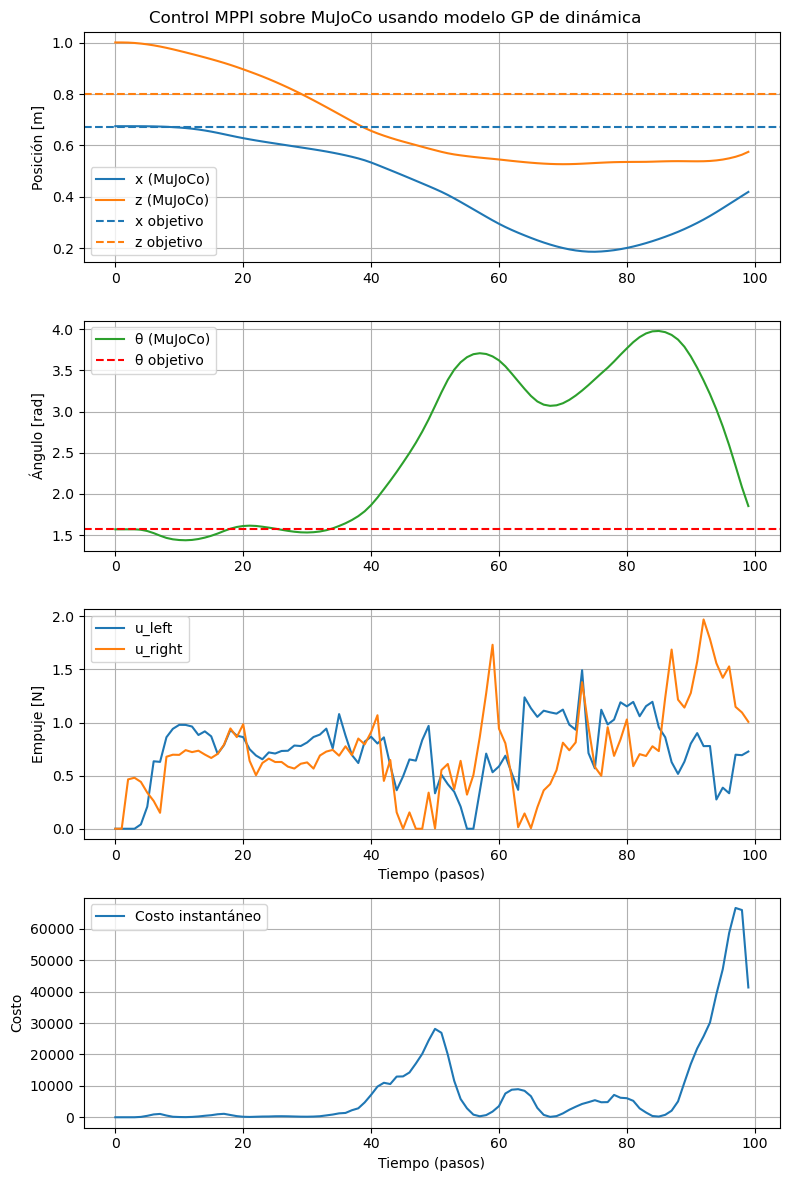

In [47]:
# =====================================================
# 5️⃣ Gráficos de estado / acción / costo
# =====================================================
fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# 1) Posición x, z
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color='C1')
axes[0].axhline(goal[0], color='C0', linestyle='--', label="x objetivo")
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# 2) Ángulo θ
axes[1].plot(traj_s[:,4], label="θ (MuJoCo)", color='C2')
axes[1].axhline(goal[4], color='r', linestyle='--', label="θ objetivo")
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# 3) Acciones (empujes)
axes[2].plot(traj_u[:,0], label="u_left")
axes[2].plot(traj_u[:,1], label="u_right")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# 4) Costo instantáneo
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP de dinámica")
plt.tight_layout()
plt.show()


In [48]:
# =====================================================
# 6️⃣ Animación tipo Pendulum-v1 (si tienes frames)
# =====================================================
if len(frames) > 0:
    fig = plt.figure()
    img = plt.imshow(frames[0])

    def animate(i):
        img.set_data(frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close()

    display(HTML(ani.to_html5_video()))

else:
    print("⚠️ No se capturaron frames. Añade tu función de render y apéndalos en 'frames'.")


In [39]:
print(traj_s[:,0])

[ 6.75000012e-01  6.75000012e-01  6.74998164e-01  6.74975336e-01
  6.74889624e-01  6.74686611e-01  6.74309850e-01  6.73708498e-01
  6.72839165e-01  6.71665251e-01  6.70267761e-01  6.68543756e-01
  6.66403413e-01  6.63818419e-01  6.60772264e-01  6.57249868e-01
  6.53236449e-01  6.48738325e-01  6.43758059e-01  6.38267815e-01
  6.32258356e-01  6.25712454e-01  6.18583202e-01  6.10772848e-01
  6.02093399e-01  5.92176259e-01  5.80288529e-01  5.65326929e-01
  5.47348738e-01  5.27827382e-01  5.07471621e-01  4.86420691e-01
  4.64686155e-01  4.42331970e-01  4.19395953e-01  3.95799041e-01
  3.71489763e-01  3.46489429e-01  3.20870101e-01  2.94774354e-01
  2.68419713e-01  2.42048025e-01  2.15826526e-01  1.89834505e-01
  1.64303601e-01  1.39433056e-01  1.15415663e-01  9.23951790e-02
  7.04630166e-02  4.97092269e-02  3.02017797e-02  1.19634103e-02
 -5.01343189e-03 -2.06790697e-02 -3.49775441e-02 -4.78706472e-02
 -5.93445562e-02 -6.94039837e-02 -7.80658945e-02 -8.53535980e-02
 -9.12922397e-02 -9.59102

In [ ]:
# ===============================================
# 1️⃣ Setup e imports
# ===============================================
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import time, os
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Configuración base de MuJoCo
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

# Función para hacer un paso en la simulación
def step_sim(data, ctrl):
    data.ctrl[:] = ctrl
    mj.mj_step(model, data)
    return np.array([
        data.sensor("pos_drone").data[0],   # x
        data.sensor("pos_drone").data[2],   # z
        data.qvel[0],                       # x'
        data.qvel[2],                       # z'
        data.qpos[1],                       # θ (asumiendo 2° DoF rotacional)
        data.qvel[1],                       # θ'
    ])

print("✅ Simulador inicializado correctamente.")


## Data collection

In [ ]:
# ===============================================
# 2️⃣ Recolección de datos del simulador
# ===============================================

# Función para "desenvolver" ángulos
def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos, extendiendo más allá de [-π, π].
    """
    if angle_prev is None:
        return angle_raw

    # diferencia cruda
    delta = angle_raw - angle_prev

    # si cruzó el límite, corrige ±2π
    if delta > np.pi:
        angle_raw -= 2*np.pi
    elif delta < -np.pi:
        angle_raw += 2*np.pi

    return angle_raw


# Función para convertir cuaternión a ángulo de pitch (Y)
def quat_to_pitch_y(quat, prev_roll=None):
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None, dt=0.01):
    # --- Posición global ---
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # --- Velocidades lineales del cuerpo (provenientes de MuJoCo) ---
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # --- Cuaternión del dron ---
    quat = data.sensor("quat_drone").data   # [w,x,y,z]

    # --- Roll instantáneo ---
    roll_raw = quat_to_pitch_y(quat)

    # --- Roll continuo con unwrap ---
    if prev_theta is None:
        theta = roll_raw
    else:
        delta = roll_raw - prev_theta
        if delta > np.pi:
            roll_raw -= 2*np.pi
        elif delta < -np.pi:
            roll_raw += 2*np.pi
        theta = roll_raw

    # --- Velocidad angular: eje X = roll ---
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]   # solo el roll

    state = np.array([x, z, x_dot, z_dot, theta, theta_dot])
    return state, theta





def rollout_random(model, data, n_steps=10000, dt=0.01):
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps)):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        # Acción aleatoria
        a_t = np.random.uniform(0.0, step/n_steps*2.0, size=2) # fuerza entre 0 y 2*N, escalada con el tiempo
        data.ctrl[:] = a_t

        # Avanzar simulación
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    return np.array(states), np.array(actions), np.array(next_states)





# Ejecutar recolección
states, actions, next_states = rollout_random(model, data, n_steps=2000, dt=0.01)

# Guardar diferencias (delta_s)
delta_s = next_states - states

print("✅ Datos recolectados:", states.shape, actions.shape, delta_s.shape)


In [3]:
# ===============================================
# 3️⃣ Visualización de los datos recolectados
# ===============================================

rng = 2000
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()



NameError: name 'plt' is not defined

## Gaussian Process Training

In [ ]:
# ===============================================
# Imports for GP model
# ===============================================   
import torch
import gpytorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device GP:", device)


# ===============================================
# Build training data for GP model
# ===============================================
# states: (N, 6)
# actions: (N, 2)
# delta_s: (N, 6)

state_dim = states.shape[1]   # 6
act_dim   = actions.shape[1]  # 2
out_dim   = delta_s.shape[1]  # 6

X_full = np.hstack([states, actions])  # (N, 8)
Y_full = delta_s                       # (N, 6)

N = X_full.shape[0]
print("X_full:", X_full.shape, "Y_full:", Y_full.shape)


# ===============================================
# Sample training data for GP model 
# ===============================================
# Número de puntos de entrenamiento para el GP
N_train = 5000   # puedes ajustarlo (2k–10k típico)

idx = np.random.choice(N, size=N_train, replace=False)

X_train_np = X_full[idx]
Y_train_np = Y_full[idx]

print("Train set:", X_train_np.shape, Y_train_np.shape)


# ===============================================
# Normalize training data for GP model
# ===============================================

# Normalización input
X_mean = X_train_np.mean(axis=0, keepdims=True)
X_std  = X_train_np.std(axis=0, keepdims=True) + 1e-8

# Normalización output
Y_mean = Y_train_np.mean(axis=0, keepdims=True)
Y_std  = Y_train_np.std(axis=0, keepdims=True) + 1e-8

X_train_norm = (X_train_np - X_mean) / X_std
Y_train_norm = (Y_train_np - Y_mean) / Y_std

# A tensores en GPU
X_train_t = torch.tensor(X_train_norm, dtype=torch.float32, device=device)  # (Ntrain, 8)
Y_train_t = torch.tensor(Y_train_norm, dtype=torch.float32, device=device)  # (Ntrain, 6)

num_tasks = out_dim  # 6


# ===============================================
# Define and instantiate the GP model
# ===============================================

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            base_mean=gpytorch.means.ConstantMean(),
            num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            ),
            num_tasks=num_tasks,
            rank=1,  # baja dimensión para la correlación entre tareas
        )

    def forward(self, x):
        mean_x = self.mean_module(x)      # (N, num_tasks)
        covar_x = self.covar_module(x)    # multitask kernel
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

model = MultitaskGPModel(X_train_t, Y_train_t, likelihood).to(device)
print(model)


# ===============================================
# Train the GP model
# ===============================================

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100  # ajustable

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train_t)           # MultitaskMultivariateNormal
    loss = -mll(output, Y_train_t)
    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - loss: {loss.item():.4f}")







In [ ]:
import os, joblib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Crear carpeta si no existe
os.makedirs("data/gp_models", exist_ok=True)

# Entradas = estado + acción   -> (N, 8)
X = np.hstack([states, actions])  # [x, z, ẋ, ż, θ, θ̇, u_left, u_right]
Y = delta_s                       # (N, 6)

# Archivos donde se guardarán los modelos (uno por cada dimensión de delta_s)
model_paths = [f"data/gp_models/gp_model_{i}.pkl" for i in range(Y.shape[1])]

# Kernel compartido
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))

gps = []
all_exist = all(os.path.exists(p) for p in model_paths)

if all_exist:
    print("📂 Cargando modelos GP guardados...")
    for path in model_paths:
        gps.append(joblib.load(path))
    print("✅ Modelos cargados correctamente.")
else:
    print("⚙️ Entrenando nuevos modelos Gaussian Process...")
    for i in tqdm(range(Y.shape[1])):
        gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            n_restarts_optimizer=2,
            random_state=0,
        )
        gp.fit(X, Y[:, i])
        gps.append(gp)
        joblib.dump(gp, model_paths[i])
    print("✅ Entrenamiento y guardado completo.")


## Validation and Visualization

In [ ]:
# ===============================================
# 4️⃣ Diagnóstico y visualización del modelo GP
# ===============================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Recalcular predicciones sobre un subconjunto de datos
idx = np.random.choice(len(X), size=500, replace=False)
X_test, Y_true = X[idx], Y[idx]
Y_pred = np.zeros_like(Y_true)

# Predicciones por modelo
for i in range(Y_true.shape[1]):
    Y_pred[:, i] = gps[i].predict(X_test)

# --------------------------
# 1️⃣ Scatter: Pred vs Real
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$\Delta x$', r'$\Delta z$', r'$\Delta \dot{x}$', r'$\Delta \dot{z}$', r'$\Delta \theta$', r'$\Delta \dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_true[:, i], Y_pred[:, i], s=10, alpha=0.6)
    ax.plot([Y_true[:, i].min(), Y_true[:, i].max()],
            [Y_true[:, i].min(), Y_true[:, i].max()], 'r--')
    ax.set_title(f"{labels[i]} | R²={r2_score(Y_true[:, i], Y_pred[:, i]):.3f}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicción")

plt.suptitle("Predicción vs Real (subconjunto de test)")
plt.tight_layout()
plt.show()

# --------------------------
# 2️⃣ Curva 1D con incertidumbre
# --------------------------
# Elegimos una variable y analizamos su dependencia con z (altura)
var_idx = 1  # Ejemplo: delta z
dim = 1      # Analizamos dependencia con z

# Barrido de una variable (z) manteniendo el resto fijo
z_values = np.linspace(X[:, dim].min(), X[:, dim].max(), 100)
X_base = np.mean(X, axis=0)
X_curve = np.tile(X_base, (100, 1))
X_curve[:, dim] = z_values

# Predicción con incertidumbre
y_mean, y_std = gps[var_idx].predict(X_curve, return_std=True)

plt.figure(figsize=(8,5))
plt.plot(z_values, y_mean, label='Predicción media')
plt.fill_between(z_values, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.3, label='±2σ')
plt.xlabel("Altura z")
plt.ylabel(f"{labels[var_idx]}")
plt.title("Curva 1D con incertidumbre (modelo GP)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Fase: posición vs velocidad (modelo vs datos)
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(states[:,1], states[:,3], s=4, alpha=0.4, label="Datos simulador")
plt.scatter(states[idx,1], states[idx,3]+Y_pred[:,3], s=4, alpha=0.4, label="Predicción GP")
plt.xlabel("Posición z")
plt.ylabel("Velocidad z'")
plt.title("Fase posición–velocidad (real vs modelo)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4️⃣ Errores por variable
# --------------------------
errors = Y_pred - Y_true
rmse = np.sqrt(np.mean(errors**2, axis=0))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(range(6), rmse)
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel("RMSE")
ax.set_title("Error cuadrático medio por dimensión")
plt.show()

# --------------------------
# 5️⃣ Distribución de errores (histogramas)
# --------------------------
fig, axes = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flat):
    ax.hist(errors[:,i], bins=30, alpha=0.7)
    ax.set_title(f"{labels[i]} (σ={np.std(errors[:,i]):.3e})")
plt.suptitle("Distribución de errores del GP")
plt.tight_layout()
plt.show()


# --------------------------
# 6️⃣ Visualización 3D de los estados
# --------------------------
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(states[:,0], states[:,1], states[:,3], s=5, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("z'")
ax.set_title("Distribución de estados en el espacio 3D")
plt.show()


In [ ]:
# Elegimos una secuencia continua de índices
t0 = 0
T = 500
X_seq = X[t0:t0+T]
Y_seq_true = Y[t0:t0+T]

Y_seq_pred = np.zeros_like(Y_seq_true)
for i in range(Y_seq_true.shape[1]):
    Y_seq_pred[:, i] = gps[i].predict(X_seq)

# Reconstruimos el estado siguiente
s_seq      = states[t0:t0+T]        # s_t
s_seq_true = states[t0+1:t0+T+1]    # s_{t+1} real
s_seq_pred = s_seq + Y_seq_pred     # s_{t+1} predicho

time = np.arange(T)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(time, s_seq_true[:,0], label="x real")
plt.plot(time, s_seq_pred[:,0], '--', label="x GP")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_seq_true[:,1], label="z real")
plt.plot(time, s_seq_pred[:,1], '--', label="z GP")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Trayectoria 1-step-ahead: MuJoCo vs GP")
plt.tight_layout()
plt.show()




plt.figure(figsize=(6,6))

# Trayectoria real (MuJoCo)
plt.plot(s_seq_true[:, 0],  # x
         s_seq_true[:, 1],  # z
         label="MuJoCo (real)", alpha=0.8)

# Trayectoria predicha por el GP (1-step-ahead)
plt.plot(s_seq_pred[:, 0],  # x
         s_seq_pred[:, 1],  # z
         '--', label="GP (1-step)", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: MuJoCo vs GP")
plt.legend()
plt.grid(True)
plt.axis('equal')   # para que las escalas de x y z no se deformen
plt.show()



In [ ]:

# ==============================================
# 5️⃣ Visualización de actitudes (θ y θ') real vs GP
# ==============================================

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, s_seq_true[:,4], label="θ real")
plt.plot(time, s_seq_pred[:,4], '--', label="θ GP")
plt.xlabel("timestep")
plt.ylabel("θ")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, s_seq_true[:,5], label="θ' real")
plt.plot(time, s_seq_pred[:,5], '--', label="θ' GP")
plt.xlabel("timestep")
plt.ylabel("θ'")
plt.grid(True)
plt.legend()

plt.suptitle("Actitud del dron: real vs GP")
plt.tight_layout()
plt.show()


In [ ]:
# ===============================================
# 5️⃣ Rollout multi-step usando el modelo GP
# ===============================================

t0 = 1000
T = 100

s_true_traj = states[t0:t0+T+1]       # s_t ... s_{t+T}
a_traj      = actions[t0:t0+T]        # a_t ... a_{t+T-1}

# Rollout del GP
s_gp = [s_true_traj[0].copy()]        # empezamos en s_t0 real
s    = s_true_traj[0].copy()

for k in range(T):
    s_k   = s
    a_k   = a_traj[k]
    x_in  = np.hstack([s_k, a_k]).reshape(1, -1)

    # predecimos Δs
    delta_pred = np.array([gp.predict(x_in)[0] for gp in gps])
    s          = s_k + delta_pred
    s_gp.append(s.copy())

s_gp = np.array(s_gp)                 # shape (T+1, dim_s)

time = np.arange(T+1)


plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, s_true_traj[:,0], label="x MuJoCo")
plt.plot(time, s_gp[:,0], '--', label="x GP rollout")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_true_traj[:,1], label="z MuJoCo")
plt.plot(time, s_gp[:,1], '--', label="z GP rollout")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Rollout multi-step: MuJoCo vs GP (usando mismas acciones)")
plt.tight_layout()
plt.show()


# Visualización de la trayectoria en el plano x–z

plt.figure(figsize=(6,6))

plt.plot(s_true_traj[:,0], s_true_traj[:,1],
         label="MuJoCo (real)", alpha=0.8)

plt.plot(s_gp[:,0], s_gp[:,1],
         '--', label="GP rollout", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: simulador vs GP (multi-step)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


#  MPPI Controller

In [ ]:
# ==============================================
# 6️⃣ Helper functions para control MPPI
# ==============================================

import numpy as np

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
act_dim   = 2   # [u_left, u_right]


def predict_next_gp(s, a, gps):
    """
    s: estado actual (6,)
    a: acción actual (2,)
    gps: lista de 6 modelos GP, cada uno predice una componente de Δs
    devuelve: s_next (6,)
    """
    x = np.hstack([s, a]).reshape(1, -1)  # (1, 8)
    delta = np.zeros(state_dim)
    for i, gp in enumerate(gps):
        delta[i] = gp.predict(x)[0]
    return s + delta


In [ ]:
# ==============================================
# 7️⃣ Control MPPI usando el modelo GP
# ===============================================

def cost_function(
    s, a,
    goal=np.array([0.0, 1.0, 0, 0, 1.57, 0]),
    weights=None
):
    """
    s = [x, z, x_dot, z_dot, theta, theta_dot]
    a = [u1, u2]
    """
    if weights is None:
        weights = dict(
            x_pos=0.0,
            z_pos=3.0,
            x_vel=0.5,
            z_vel=1.0,
            theta=0.0,
            theta_dot=1.0,
            ctrl_effort=0.1,
            ctrl_asym=0.05,
        )

    x_err        = s[0] - goal[0]
    z_err        = s[1] - goal[1]
    x_vel_err    = s[2]
    z_vel_err    = s[3]
    theta_err    = s[4] - goal[4]
    theta_dot_err = s[5]

    ctrl_effort  = np.linalg.norm(a - np.array([1.0, 1.0]))
    ctrl_asym    = np.abs(a[0] - a[1])

    cost = (
        weights["x_pos"]      * x_err**2
        + weights["z_pos"]    * z_err**2
        + weights["x_vel"]    * x_vel_err**2
        + weights["z_vel"]    * z_vel_err**2
        + weights["theta"]    * theta_err**2
        + weights["theta_dot"]* theta_dot_err**2
        + weights["ctrl_effort"] * ctrl_effort**2
        + weights["ctrl_asym"]   * ctrl_asym**2
    )
    return cost


def mppi_control(
    s0,
    u_mean,
    gps,
    goal,
    weights,
    N=80,
    H=20,
    lambda_=1.0,
    sigma_u=0.2
):
    """
    s0:    estado actual (6,)
    u_mean: secuencia nominal (H, 2)
    gps:   lista de GPs
    goal:  estado objetivo
    weights: pesos de costo
    """
    noise   = np.random.randn(N, H, 2) * sigma_u
    costs   = np.zeros(N)
    actions = np.zeros((N, H, 2))

    for n in range(N):
        s = np.copy(s0)
        cost = 0.0
        for t in range(H):
            u_t = np.clip(u_mean[t] + noise[n, t], u_min, u_max)
            s = predict_next_gp(s, u_t, gps)
            cost += cost_function(s, u_t, goal, weights)
            actions[n, t] = u_t
        costs[n] = cost

    # Softmin (importancia)
    beta = np.min(costs)
    w = np.exp(-(costs - beta) / lambda_)
    w /= np.sum(w)

    # Actualizar secuencia nominal
    for t in range(H):
        u_mean[t] = np.sum(w[:, None] * actions[:, t, :], axis=0)
    u_mean = np.clip(u_mean, u_min, u_max)

    # Receding horizon
    u_opt = u_mean[0].copy()
    u_mean[:-1] = u_mean[1:]
    u_mean[-1]  = u_mean[-2]

    return u_opt, u_mean # acción óptima y secuencia actualizada



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import mujoco as mj

# =====================================================
# 0️⃣ Parámetros MPPI y objetivo
# =====================================================

H = 10         # pasos de predicción
N = 100          # rollouts (muestras)
lambda_ = 1.0
sigma_u = 0.2

u_min = np.array([0.0, 0.0])
u_max = np.array([2.0, 2.0])
u_init = np.array([1.0, 1.0])

goal = np.array([0.0, 1.0, 0, 0, 0, 0])

weights_custom = dict(
    x_pos=0.5,  z_pos=4.0,
    x_vel=0.5,  z_vel=1.0,
    theta=0.5,  theta_dot=0.5,
    ctrl_effort=0.1, ctrl_asym=0.05
)

T = 500   # pasos de control / frames

width, height = 640, 480

# Para guardar resultados
traj_s, traj_u, traj_cost = [], [], []
frames = []

# =====================================================
# 1️⃣ Context manager del Renderer (se auto-cierra)
# =====================================================

with mj.Renderer(model, height=height, width=width) as renderer:
    # Cámara
    cam = mj.MjvCamera()
    mj.mjv_defaultCamera(cam)

    # Ajusta estos valores (idealmente los que encontraste en tu test)
    cam.lookat   = np.array([0.3, 0.0, 0.8])
    cam.distance = 3.0
    cam.elevation = -20.0
    cam.azimuth   = 90.0

    # Reset simulador
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    prev_theta = None
    s, prev_theta = get_state_from_sensors(data, prev_theta)

    u_mean = np.tile(u_init, (H, 1))

    # 🔁 Loop de control + simulación + render
    for t in tqdm(range(T)):
        # --- MPPI: acción óptima usando el GP como modelo interno ---
        u, u_mean = mppi_control(
            s0     = s,
            u_mean = u_mean,
            gps    = gps,
            goal   = goal,
            weights= weights_custom,
            N      = N,
            H      = H,
            lambda_= lambda_,
            sigma_u= sigma_u
        )

        # --- Aplicar acción en MuJoCo ---
        data.ctrl[:] = u
        mj.mj_step(model, data)

        # --- Nuevo estado real ---
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # --- Log para análisis ---
        traj_s.append(s_next)
        traj_u.append(u)
        traj_cost.append(cost_function(s, u, goal, weights_custom))
        s = s_next.copy()

        # --- Renderizar frame ---
        renderer.update_scene(data, cam)
        rgb = renderer.render()
        frames.append(rgb.copy())

# 💡 Aquí ya se llamó automáticamente a renderer.close()

traj_s = np.array(traj_s)
traj_u = np.array(traj_u)
traj_cost = np.array(traj_cost)



In [ ]:
# =====================================================
# 2️⃣ Gráficos de estado / acción / costo
# =====================================================

fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# Posición
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color ='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color ='C1')
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# Ángulo
axes[1].plot(traj_s[:,4], label="θ (MuJoCo)")
axes[1].axhline(np.pi/2, color='r', linestyle='--')
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# Control
axes[2].plot(traj_u[:,0], label="u_left")
axes[2].plot(traj_u[:,1], label="u_right")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# Costo
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP")
plt.tight_layout()
plt.show()

# =====================================================
# 3️⃣ Animación tipo Pendulum-v1
# =====================================================

fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
plt.close()

HTML(ani.to_html5_video())